In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from fmskill import ModelResult, PointObservation, TrackObservation, Connector
%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\hewr\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Observations

In [2]:
o1 = PointObservation('../tests/testdata/SW/HKNA_Hm0.dfs0', item=0, x=4.2420, y=52.6887, name="HKNA")
o2 = PointObservation("../tests/testdata/SW/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = TrackObservation("../tests/testdata/SW/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [3]:
mrMIKE = ModelResult('../tests/testdata/SW/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)

## NetCDF ModelResult

In [4]:
fn = r"..\tests\testdata\SW\ERA5_DutchCoast.nc"

In [5]:
mr = ModelResult(fn, name='ERA5')

C:\Users\hewr\Anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
mr

<XArrayModelResult> 'ERA5'
- Item: 0: mwd
- Item: 1: mwp
- Item: 2: mp2
- Item: 3: pp1d
- Item: 4: swh

In [7]:
mr.ds  # mr contains the xr.Dataset

<xarray.Dataset>
Dimensions:  (time: 67, x: 20, y: 11)
Coordinates:
  * x        (x) float32 -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.0 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 55.0 54.5 54.0 53.5 53.0 52.5 52.0 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd      (time, y, x) float32 ...
    mwp      (time, y, x) float32 ...
    mp2      (time, y, x) float32 ...
    pp1d     (time, y, x) float32 ...
    swh      (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## ModelResultItem
We can select an item from the NetCDF file be using square brackets refering either to the item name or number. 

In [8]:
mr['swh']

<XArrayModelResultItem> 'ERA5'
- Item: swh

## Test extract from XArray

In [9]:
mr['swh']._extract_point(o1).head()

,x,y,ERA5
time,,,
2017-10-27 00:00:00,4.242,52.6887,1.220337
2017-10-27 01:00:00,4.242,52.6887,1.346573
2017-10-27 02:00:00,4.242,52.6887,1.465747
2017-10-27 03:00:00,4.242,52.6887,1.611757
2017-10-27 04:00:00,4.242,52.6887,1.792901


In [10]:
mr['swh'].extract_observation(o1)  # will call _extract_point

<PointComparer>
Observation: HKNA, n_points=386
 Model: ERA5, rmse=0.545

In [11]:
mr['swh']._extract_track(o3).head()

,x,y,ERA5
time,,,
2017-10-27 12:52:52.337,2.422854,51.253353,1.438809
2017-10-27 12:52:53.280,2.413789,51.310268,1.464191
2017-10-27 12:52:54.224,2.404711,51.367184,1.489200
2017-10-27 12:52:55.167,2.395619,51.424099,1.513833
2017-10-27 12:52:56.111,2.386516,51.481014,1.538092


## xarray mfdataset ModelResult

Use mfdataset to load multiple files.

In [12]:
fn = r"..\tests\testdata\SW\CMEMS_DutchCoast_*.nc"
ds = xr.open_mfdataset(fn)
mr2 = ModelResult(ds, name='CMEMS')

simple extraction of one item

In [13]:
mr2['VHM0'].extract_observation(o1)

<PointComparer>
Observation: HKNA, n_points=242
 Model: CMEMS, rmse=0.882

In [14]:
mr2['VHM0'].extract_observation(o3)

<TrackComparer>
Observation: c2, n_points=123
 Model: CMEMS, rmse=0.448

## xarray grib data ModelResult

ToDo

In [15]:
#fn = r"..\tests\testdata\SW\NWW3_hs_201710.grib"
#ds = xr.load_dataset(fn, engine='cfgrib')

## Connect multiple models and observations and extract

In [16]:
mrERA5 = mr['swh']
mrCMEMS = mr2['VHM0']
con = Connector([o1,o2,o3], [mrERA5, mrCMEMS, mrMIKE])

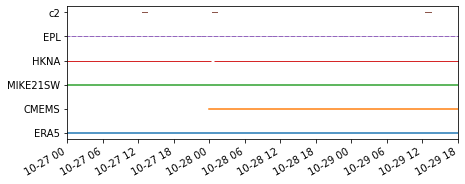

In [17]:
con.plot_temporal_coverage(show_model=True);

In [18]:
cc = con.extract()

## Analysis and plotting
Which model is better? 

In [19]:
sk = cc.skill()
sk.style()

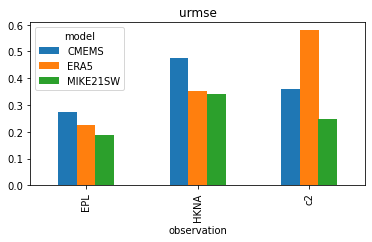

In [20]:
sk.plot_bar('urmse', figsize=(6,3));

In [21]:
cc.mean_skill().style(columns=[])

,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
CMEMS,326,-0.498,0.625,0.369,0.529,0.920,0.099,0.469
ERA5,326,-0.403,0.567,0.386,0.482,0.930,0.101,0.586
MIKE21SW,326,0.006,0.342,0.259,0.276,0.962,0.070,0.850


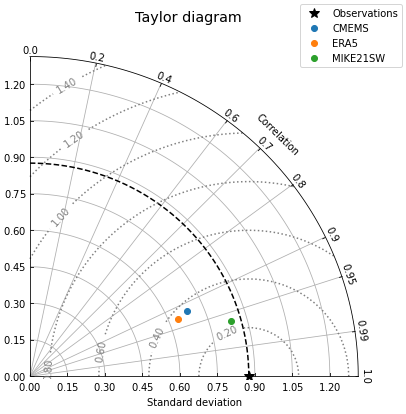

In [22]:
cc.taylor(figsize=6)